In [33]:
import numpy as np
import acor
import matplotlib.pyplot as plt

# Exercse 55

In [20]:
#functions

def getgradient(theta, b):
    """
    compute gradient of log(pi)
    
    Parameters
    ----------
    b: scalar
       parameter in density.
    theta: 1D array of length L
           value of angles on lattice
       
    Returns
    -------
    grad : scalar
           
    """
    
    L = len(theta)
    shift_theta_u = np.roll(theta, 1) - theta
    shift_theta_d = np.roll(theta, -1) - theta
    grad = 2*b*(np.sin(shift_theta_u)+np.sin(shift_theta_d))
    return grad


def updatetheta(theta, h, b):
    """
    update 
    
    Parameters
    ----------
    b: scalar
       parameter in density.
       
    theta: 1D array of length L
           value of angles on lattice
           
    h : scalar
        parameter in updating equation .
    
    Returns
    -------
    theta : 1D array of length L
            updated value of angles on lattice
           
    """
    
    L = len(theta)
    e = np.random.normal(0,1,L)
    grad = getgradient(theta, b)
    theta = theta + h*grad + np.sqrt(2*h)*e
    return theta

    
def sampleXYunMetropolize(L, N, b, h):
    theta = np.random.normal(0,1,L)
    thetas = np.zeros((N, L))
    for niter in range(N):
        theta = updatetheta(theta, h, b)
        thetas[niter,:] = theta
    return thetas

def sumcos(theta):
    shift_theta_u = np.roll(theta, 1) - theta
    shift_theta_d = np.roll(theta, -1) - theta
    sumc = np.sum(np.cos(shift_theta_u))+np.sum(np.cos(shift_theta_d)) 
    return sumc
 
def sampleXYMetropolize(L, N, b, h):
    theta = np.random.normal(0,1,L)
    thetas = np.zeros((N, L))
    for niter in range(N):
        theta_new = updatetheta(theta, h, b)
        grad = getgradient(theta, b)
        pi_new = sumcos(theta_new)
        pi_old = sumcos(theta)
        pro_old = -np.dot(np.transpose(theta_new - h*grad), (theta_new - h*grad))
        pro_new = -np.dot(np.transpose(theta + h*grad), (theta + h*grad))
        pacc = np.exp(b*(pi_new - pi_old) + h*(pro_old-pro_new))
        a = np.random.uniform(0,1)
        if a < pacc:
            theta = theta_new
        thetas[niter,:] = theta
    return thetas

def magnetization(theta):
    M_x = np.sum(np.cos(theta))
    M_y = np.sum(np.sin(theta))
    mag = M_x / np.sqrt(M_x**2 + M_y**2)
    return mag

def IAT(thetas):
    mag = np.apply_along_axis(magnetization, 1, thetas)
    tau = acor.acor(mag)[0]
    return tau

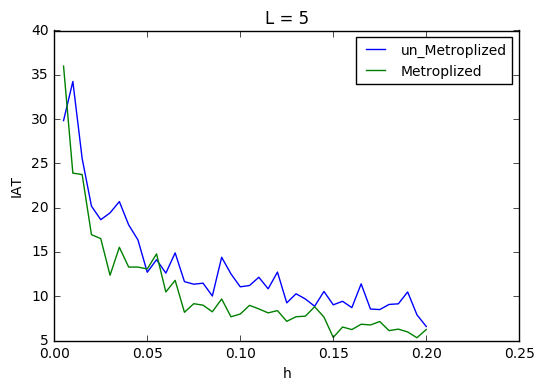

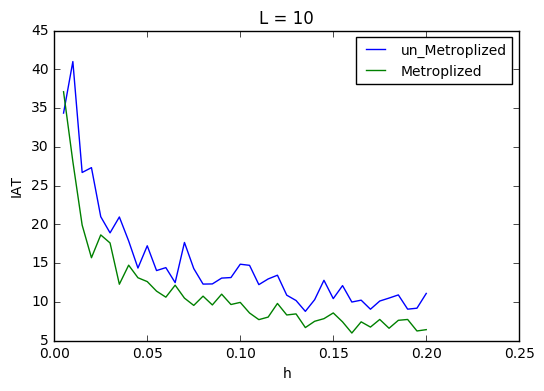

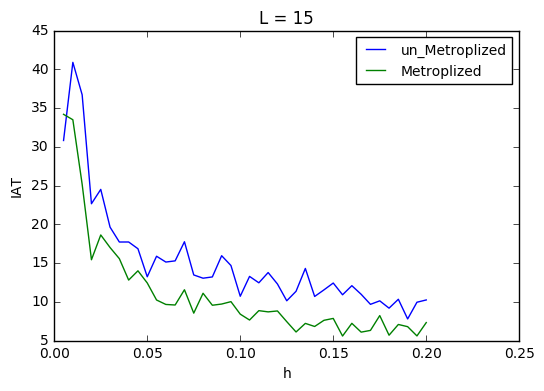

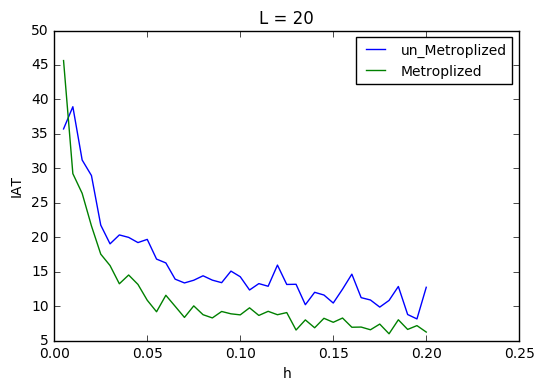

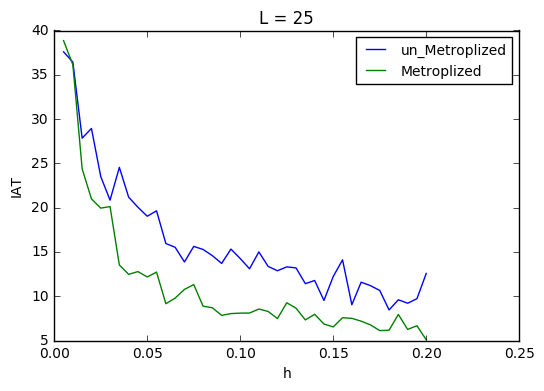

In [64]:
#compare 
N = 1000
b = 0.1
Ls = [5, 10, 15, 20, 25]
hs = np.arange(0.005, 0.205, 0.005)
index = np.arange(0,len(hs),1)
theta_nM = dict()
theta_M = dict()
iat_nM = np.zeros(len(hs))
iat_M = np.zeros(len(hs))
for L in Ls:
    for i in index:
        h = hs[i]
        for nt in range(20):
            theta_nM[i] = sampleXYMetropolize(L, N, b, h)
            theta_M[i] = sampleXYunMetropolize(L, N, b, h)
            iat_nM[i] = iat_nM[i] + IAT(theta_nM[i])
            iat_M[i] = iat_M[i] + IAT(theta_M[i])
        iat_nM[i] = iat_nM[i]/20
        iat_M[i] = iat_M[i]/20
    plt.plot(hs, iat_nM, label = 'un_Metroplized')
    plt.plot(hs, iat_M, label = 'Metroplized')
    plt.xlabel("h")
    plt.ylabel('IAT')
    plt.legend(loc='best',fontsize=10)
    plt.title('L = {}'.format(L))
    plt.show()

I set $\beta$ = 0.1, iteration times N = 1000, tried differnt h and L. When cmputing each integrated autocorrelation time, I repelicate 20 times and take the average. From the plots above we can see that the integrated autocorrelation time of un-Metropolized scheme is a little bit bigger than that of Metropolized scheme.
Both IATs from two methods decrease as h increases. And the advantage of Metropolized method become significant as h increases as the IATs of Metropolized method are almost always smaller. When L increases, the advantage of Metropolized method also become significant.

# Exercise 56

In [72]:
# I choose K to be exp(-|x|^2/2), J is identity
def VV_oneStep(theta1, theta2, h, L, b):
    
    grad1 = getgradient(theta1, b)
    theta2_13 = theta2 + 0.5 * h * grad1 
    theta1_new = theta1 + h * theta2_13
    grad2 = getgradient(theta1_new, b)
    theta2_new = theta2_13 + 0.5 * h * grad2 
 
    return theta1_new, theta2_new

def VV_update(theta1, theta2, h, L, n, b):
    for i in range(n):
        theta1, theta2 = VV_oneStep(theta1, theta2, h, L, b)
    return theta1, theta2

def VV_Met_update(theta1, theta2, theta1_new, theta2_new, b):
    p1_new = sumcos(theta1_new)
    p1_old = sumcos(theta1)
    delta = -0.5 * (np.dot(theta2_new, theta2_new) - np.dot(theta2, theta2))
    pacc = np.exp(b*(p1_new - p1_old) + delta)
    if np.random.rand() < pacc:
        return theta1_new
    else:
        return theta1

def Hybrid_update(theta1, h, b, L, n, Met = False):
    theta2 = np.random.normal(0, 1, L)
    theta1_new, theta2_new = VV_update(theta1, theta2, h, L, n, b)
    if Met:
        theta1_new =  VV_Met_update(theta1, theta2, theta1_new, theta2_new, b)
    return theta1_new

def Hybrid(L, N, b, h, n, Met = False):
    theta = np.random.normal(0,1,L)
    thetas = np.zeros((N, L))
    thetas[0,:] = theta              
    for niter in range(1, N):
        thetas[niter,:] = Hybrid_update(thetas[niter-1,:], h, b, L, n, Met)
    return thetas

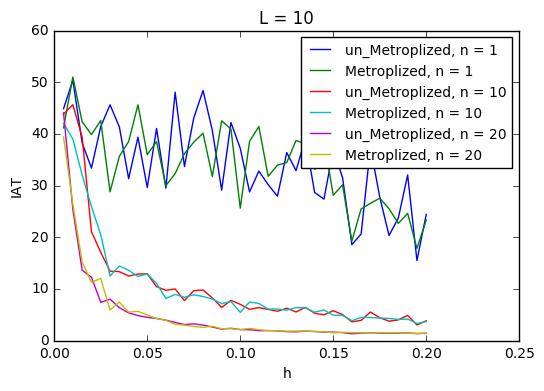

In [82]:
L=10
N=1000
b=0.1
ns = [1, 10, 20]
hs = np.arange(0.005, 0.205, 0.005)
index = np.arange(0,len(hs),1)
theta_uM = dict()
theta_M = dict()
iat_uM = np.zeros(len(hs))
iat_M = np.zeros(len(hs))
for n in ns:
    for i in index:
        h = hs[i] 
        for nt in range(10):
            theta_uM[i] = Hybrid(L, N, b, h, n, Met = False)
            theta_M[i] = Hybrid(L, N, b, h, n, Met = True)
            iat_uM[i] = iat_uM[i] + IAT(theta_uM[i])
            iat_M[i] = iat_M[i] + IAT(theta_M[i])
        iat_uM[i] = iat_uM[i]/10
        iat_M[i] = iat_M[i]/10
    plt.plot(hs, iat_uM, label = 'un_Metroplized, n = {}'.format(n))
    plt.plot(hs, iat_M, label = 'Metroplized, n = {}'.format(n))
    plt.xlabel("h")
    plt.ylabel('IAT')
plt.legend(loc='best',fontsize=10)
plt.title('L = {}'.format(L))
plt.show()

I choose K to be $\exp^{}(-|x|^{2}/2)$, J is identity, $\beta=0.1$. I replicate 10 times when computing IAT and take the average. I tried n = 1, 10, 20. Compared with the plot(L=10) above, we can see that the IATs and its variance using method in this question when n is larger than 10 are smaller that those using method in exercise 55 both with or without Metropolized scheme. When n gets larger the advantage gets significant. And the difference between using Metropolize or not is very small in this question. But if n is small, like n=1, method in this question is not as good as in exercise 56.

# Exercise 57

In [86]:
def UL_update(theta, L, b, h, gamma, Met): 
    theta1 = theta[:L]
    theta2 = theta[L:]
    
    grad1 = getgradient(theta1, b)
    theta2_13 = theta2 + 0.5 * h *  grad1
    
    theta1_12 = theta1 + 0.5 * h * theta2_13
    
    xi = np.random.normal(0, 1, L)
    theta2_23 = np.exp(-gamma * h) * theta2_13 + np.sqrt(1 - np.exp(-2 * gamma * h)) * xi

    theta1_new = theta1_12 + 0.5 * h * theta2_23 

    grad2 = getgradient(theta1_new, b)
    theta2_new = theta2_23 + 0.5 * h * grad2 
    
    if Met:
        theta1_new, theta2_new = UL_Met_update(theta1, theta2, theta1_new, theta2_new, L, b, h, gamma)

    return np.concatenate((theta1_new, theta2_new))

def UL_Met_update(theta1, theta2, theta1_new, theta2_new, L, b, h, gamma):
    p1_new = sumcos(theta1_new)
    p1_old = sumcos(theta1)
    
    delta1 = -0.5 * (np.dot(theta2_new, theta2_new) - np.dot(theta2, theta2))

    grad1 = getgradient(theta1, b)
    grad2 = getgradient(theta1_new, b)
    mu1 = np.exp(-gamma * h) * grad2 + grad1
    mu1 = -theta2 + np.exp(-gamma * h) * theta2_new - 0.5* h *  mu1
    mu2 = np.exp(-gamma * h) * grad1 + grad2
    mu2 = theta2_new - np.exp(-gamma * h) * theta2 - 0.5 * h * mu2
    delta2 = (-np.dot(mu1, mu1) + np.dot(mu2, mu2))/(2*(1-np.exp(-2*h*gamma)))

    pacc = np.exp(b*(p1_new - p1_old) + delta1 + delta2)
    if np.random.rand() < pacc:
        return theta1_new, theta2_new
    else:
        return theta1, -theta2
    
def UL(L, N, b, h, gamma, Met = False):
    theta = np.random.normal(0,1,2*L)
    thetas = np.zeros((N, 2*L))
    thetas[0,:] = theta              
    
    for niter in range(1, N):
        thetas[niter,:] = UL_update(thetas[niter-1,:], L, b, h, gamma, Met)
        
    return thetas
    

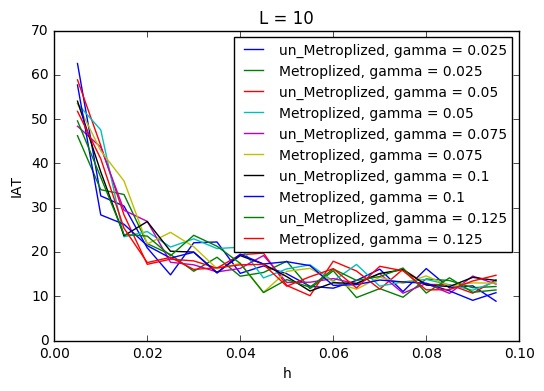

In [87]:
L=10
N=1000
b=0.1
gammas = np.arange(0.025, 0.15, 0.025)
hs = np.arange(0.005, 0.1, 0.005)
index = np.arange(0,len(hs),1)
theta_uM = dict()
theta_M = dict()
iat_uM = np.zeros(len(hs))
iat_M = np.zeros(len(hs))
for gamma in gammas:
    for i in index:
        h = hs[i] 
        for nt in range(10):
            theta_uM[i] = UL(L, N, b, h, gamma, Met = False)
            theta_M[i] = UL(L, N, b, h, gamma, Met = True)
            iat_uM[i] = iat_uM[i] + IAT(theta_uM[i])
            iat_M[i] = iat_M[i] + IAT(theta_M[i])
        iat_uM[i] = iat_uM[i]/10
        iat_M[i] = iat_M[i]/10
    plt.plot(hs, iat_uM, label = 'un_Metroplized, gamma = {}'.format(gamma))
    plt.plot(hs, iat_M, label = 'Metroplized, gamma = {}'.format(gamma))
plt.xlabel("h")
plt.ylabel('IAT')
plt.legend(loc='best',fontsize=10)
plt.title('L = {}'.format(L))
plt.show()

In this question, I set L=10 and tried differnt values of h and $\gamma$. I computed the IATs and make a plot above.

From the plot above we can see that the difference between using metropolized scheme or not is small. IATs decreases as h increases.$\gamma$ does not have too much effect on IAT. COmpared with the former two methods, the IAT computed in this questions are larger(10 when h is big enough).

Comparing these three schemes, I prefer the one using Algorithm4 (Exercise 56) choosing n=20, h=20. Under this setting, the IAT is the smallest(about 2).